## NOTE : For running this notebook you should download the dataset from :
###    https://www.kaggle.com/datasets/nomihsa965/traffic-signs-dataset-mapillary-and-dfg
##    and then put it in the main directory (Argos/) by "data" naming

In [146]:
import os
import json
from PIL import Image
import torch
from torchvision import transforms

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
import random
import numpy as np
import json

In [152]:
dataset_path = "../data/"
classes_json_file = os.path.join(dataset_path, "classes.json")

In [153]:
def extract_label_mapping(classes_file):
    label_map = {}
    try:
        with open(classes_file, 'r') as f:
            json_data = json.load(f)
            for class_name, details in json_data.items():
                if "classIndex" in details:
                    label_map[details["classIndex"]] = class_name
    except FileNotFoundError:
        print(f"Error: Classes file not found at {classes_file}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {classes_file}. Check file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return label_map

In [155]:
label_mapping = extract_label_mapping(classes_json_file)

In [156]:
class MTSDDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            root_dir,
            images_dir="images",
            annotations_dir="txts (YOLO)",
            transform=transforms.Compose([transforms.ToTensor()])
    ):

        self.root_directory = root_dir
        self.transform = transform

        self.images_names = sorted(
            os.listdir(
                os.path.join(self.root_directory, images_dir)
            )
        )
        self.full_images_directory = os.path.join(self.root_directory, images_dir)
        self.full_annotations_directory = os.path.join(self.root_directory, annotations_dir)

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        file_name = self.images_names[idx]

        img_path = os.path.join(self.full_images_directory, file_name)
        ann_path = os.path.join(self.full_annotations_directory, file_name[:-4] + '.txt')

        #print(img_path)

        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        img_tensor = self.transform(img)

        objects = []
        with open(ann_path, 'r') as f:
            for row in f.readlines():
                objects.append(row.split())
        # print(objects)

        boxes = []
        labels = []
        for obj in objects:
            # YOLO format: [class_id, x_center, y_center, width, height] (all normalized)
            class_id, cx, cy, bw, bh = map(float, obj)
            xmin = (cx - bw / 2) * w
            ymin = (cy - bh / 2) * h
            xmax = (cx + bw / 2) * w
            ymax = (cy + bh / 2) * h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(class_id))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }


        return img_tensor, target


In [157]:
dataset = MTSDDataset(dataset_path)

In [140]:
dataset[2]

(tensor([[[0.6824, 0.6745, 0.6667,  ..., 0.7020, 0.7098, 0.7137],
          [0.6353, 0.6392, 0.6431,  ..., 0.7020, 0.7098, 0.7098],
          [0.6196, 0.6275, 0.6392,  ..., 0.7059, 0.7059, 0.7098],
          ...,
          [0.9765, 0.9765, 0.9765,  ..., 0.4039, 0.4000, 0.4039],
          [0.9765, 0.9765, 0.9765,  ..., 0.3882, 0.3922, 0.3922],
          [0.9765, 0.9765, 0.9765,  ..., 0.4078, 0.4118, 0.4000]],
 
         [[0.8000, 0.7922, 0.7843,  ..., 0.8157, 0.8235, 0.8275],
          [0.7529, 0.7569, 0.7608,  ..., 0.8157, 0.8235, 0.8235],
          [0.7373, 0.7451, 0.7569,  ..., 0.8196, 0.8196, 0.8235],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.4314, 0.4275, 0.4314],
          [1.0000, 1.0000, 1.0000,  ..., 0.4157, 0.4196, 0.4196],
          [1.0000, 1.0000, 1.0000,  ..., 0.4353, 0.4392, 0.4275]],
 
         [[0.9412, 0.9333, 0.9255,  ..., 0.9412, 0.9490, 0.9529],
          [0.8941, 0.8980, 0.9020,  ..., 0.9412, 0.9490, 0.9490],
          [0.8784, 0.8863, 0.8980,  ...,

In [158]:

def draw_sample(dataset, label_map=label_mapping):
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]
    image = F.to_pil_image(image)
    boxes = target['boxes']
    labels = target['labels']

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box.tolist()
        label = labels[i].item()
        class_name = label_map[label] if label_map else str(label)

        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            xmin, ymin - 4, class_name,
            color='red', fontsize=10, weight='bold'
        )

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

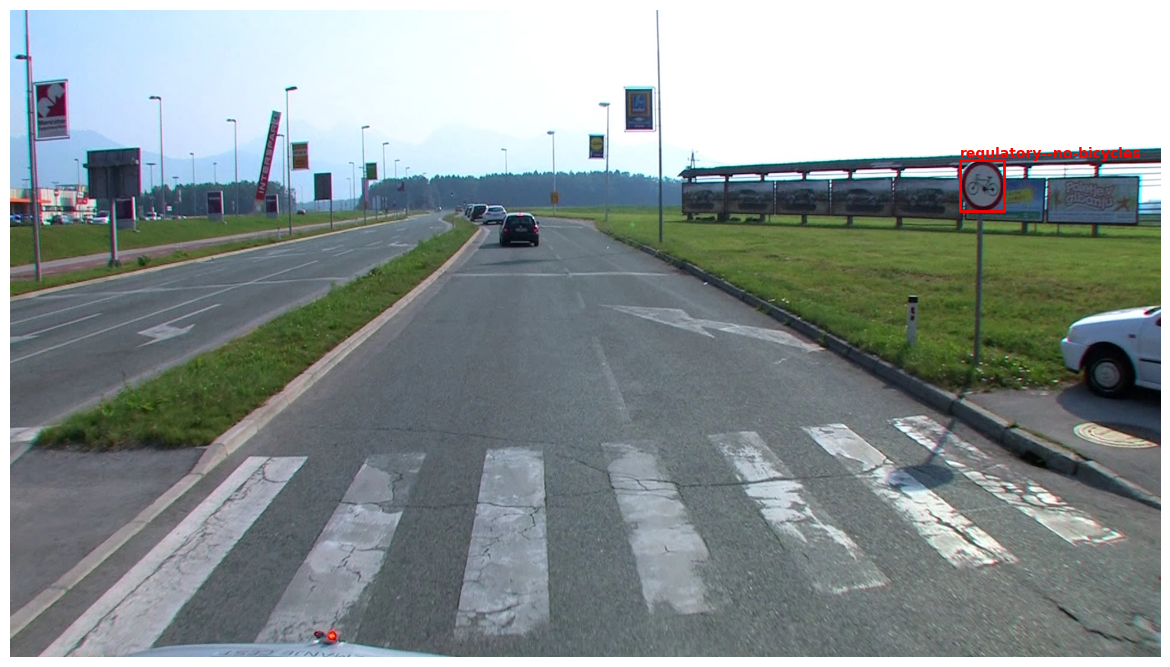

In [164]:
draw_sample(dataset)